# [TCHES 2019] Non-Profiled Deep Learning-based Side-Channel attacks with Sensitivity Analysis
https://tches.iacr.org/index.php/TCHES/article/view/7387

## 0. Configuration for DL

In [1]:
import tensorflow as tf
import keras as keras
import keras.backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, UpSampling1D, Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import numpy as np

from keras.utils import plot_model, to_categorical
import matplotlib.pyplot as plt

import datetime
import time

# 세션이 GPU의 모든 메모리를 할당받지 않고 유동적으로 필요한 만큼만 할당받도록 함.
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.tensorflow_backend.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
Sbox = [
0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
]

Sbox_inv = [
0x52, 0x09, 0x6A, 0xD5, 0x30, 0x36, 0xA5, 0x38, 0xBF, 0x40, 0xA3, 0x9E, 0x81, 0xF3, 0xD7, 0xFB,
0x7C, 0xE3, 0x39, 0x82, 0x9B, 0x2F, 0xFF, 0x87, 0x34, 0x8E, 0x43, 0x44, 0xC4, 0xDE, 0xE9, 0xCB,
0x54, 0x7B, 0x94, 0x32, 0xA6, 0xC2, 0x23, 0x3D, 0xEE, 0x4C, 0x95, 0x0B, 0x42, 0xFA, 0xC3, 0x4E,
0x08, 0x2E, 0xA1, 0x66, 0x28, 0xD9, 0x24, 0xB2, 0x76, 0x5B, 0xA2, 0x49, 0x6D, 0x8B, 0xD1, 0x25,
0x72, 0xF8, 0xF6, 0x64, 0x86, 0x68, 0x98, 0x16, 0xD4, 0xA4, 0x5C, 0xCC, 0x5D, 0x65, 0xB6, 0x92,
0x6C, 0x70, 0x48, 0x50, 0xFD, 0xED, 0xB9, 0xDA, 0x5E, 0x15, 0x46, 0x57, 0xA7, 0x8D, 0x9D, 0x84,
0x90, 0xD8, 0xAB, 0x00, 0x8C, 0xBC, 0xD3, 0x0A, 0xF7, 0xE4, 0x58, 0x05, 0xB8, 0xB3, 0x45, 0x06,
0xD0, 0x2C, 0x1E, 0x8F, 0xCA, 0x3F, 0x0F, 0x02, 0xC1, 0xAF, 0xBD, 0x03, 0x01, 0x13, 0x8A, 0x6B,
0x3A, 0x91, 0x11, 0x41, 0x4F, 0x67, 0xDC, 0xEA, 0x97, 0xF2, 0xCF, 0xCE, 0xF0, 0xB4, 0xE6, 0x73,
0x96, 0xAC, 0x74, 0x22, 0xE7, 0xAD, 0x35, 0x85, 0xE2, 0xF9, 0x37, 0xE8, 0x1C, 0x75, 0xDF, 0x6E,
0x47, 0xF1, 0x1A, 0x71, 0x1D, 0x29, 0xC5, 0x89, 0x6F, 0xB7, 0x62, 0x0E, 0xAA, 0x18, 0xBE, 0x1B,
0xFC, 0x56, 0x3E, 0x4B, 0xC6, 0xD2, 0x79, 0x20, 0x9A, 0xDB, 0xC0, 0xFE, 0x78, 0xCD, 0x5A, 0xF4,
0x1F, 0xDD, 0xA8, 0x33, 0x88, 0x07, 0xC7, 0x31, 0xB1, 0x12, 0x10, 0x59, 0x27, 0x80, 0xEC, 0x5F,
0x60, 0x51, 0x7F, 0xA9, 0x19, 0xB5, 0x4A, 0x0D, 0x2D, 0xE5, 0x7A, 0x9F, 0x93, 0xC9, 0x9C, 0xEF,
0xA0, 0xE0, 0x3B, 0x4D, 0xAE, 0x2A, 0xF5, 0xB0, 0xC8, 0xEB, 0xBB, 0x3C, 0x83, 0x53, 0x99, 0x61,
0x17, 0x2B, 0x04, 0x7E, 0xBA, 0x77, 0xD6, 0x26, 0xE1, 0x69, 0x14, 0x63, 0x55, 0x21, 0x0C, 0x7D
]

In [3]:
# 모델 구조를 그림으로 출력하기 위한 함수
def display_model_structure(model, figsize = (10, 20), saveTo = 'dummy.png'):
    plot_model(model, to_file=saveTo, show_shapes = True, show_layer_names=True)
    fig = plt.figure(figsize = figsize)
    ax = plt.axes()
    ax.axis('off')
    ax.imshow(plt.imread(saveTo))
    plt.show()
    return

## 1. Configuration for ChipWhisperer-Lite

In [4]:
import chipwhisperer as cw
from tqdm import tqdm

from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.palettes import Dark2_5 as palette
import itertools

from binascii import hexlify

In [5]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'NONE'

fw_path = '../chipwhisperer-develop/hardware/victims/firmware/simpleserial-aes_jh/simpleserial-aes-{}.hex'.format(PLATFORM)

In [6]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../chipwhisperer-develop/hardware/victims/firmware/simpleserial-aes_jh
make PLATFORM=$1 CRYPTO_TARGET=$2

rm -f -- simpleserial-aes-CWLITEXMEGA.hex
rm -f -- simpleserial-aes-CWLITEXMEGA.eep
rm -f -- simpleserial-aes-CWLITEXMEGA.cof
rm -f -- simpleserial-aes-CWLITEXMEGA.elf
rm -f -- simpleserial-aes-CWLITEXMEGA.map
rm -f -- simpleserial-aes-CWLITEXMEGA.sym
rm -f -- simpleserial-aes-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- simpleserial-aes.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
-------- begin --------
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-aes.c
avr-gcc -c -mmcu=atxmega128d3 -I. -DNO_EXTRA_OPTS -fpack-struct -gdwarf-2 -DSS_VER=SS_VER_1_1 

In [7]:
scope = cw.scope()
target = cw.target(scope)
prog = cw.programmers.XMEGAProgrammer
scope.default_setup()
cw.program_target(scope, prog, fw_path)

Serial baud rate = 38400
XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3229 bytes


In [8]:
ktp = cw.ktp.Basic() # object to generate fixed/random key and text (default fixed key, random text)
key, text = ktp.next()  # get our fixed key and random text

In [9]:
trace = cw.capture_trace(scope, target, text, key)
trace_len = len(trace.wave)

print("pt: ", hexlify(trace.textin))
print("ct: ", hexlify(trace.textout))

output_notebook()
p = figure(sizing_mode='scale_width', plot_height=300)
p.line(range(0, trace_len), trace.wave, color='black')
show(p)

pt:  b'fd6aa1c82397c331a86e41f035d873a1'
ct:  b'bd792eed0f3439611be5d5dd9949ace9'


Loading BokehJS ...

## 2. Collect Side-Channel Traces

In [10]:
def collect_data(cw, ktp, scope, target, project, num_traces):
    traces = []
    pts = []
    
    # 파형 수집
    for i in tqdm(range(num_traces)):
        key, text = ktp.next()
        trace = cw.capture_trace(scope, target, text, key)
        if trace is None:
            continue
        traces.append(trace.wave)
        pts.append(np.array(trace.textin, dtype=np.int))
        project.traces.append(trace)
    
    traces = np.array(traces)
    pts = np.array(pts)
    
    # 데이터(파형 및 평문) 셔플링
    rand_idx = np.arange(0, num_traces)
    np.random.shuffle(rand_idx)
    
    power_train = traces[rand_idx]
    pt_train = pts[rand_idx]
    
    return power_train, pt_train

In [11]:
num_train_traces = 3000
project = cw.create_project("projects/aes_normal", overwrite = True)

power_train, pt_train = collect_data(cw, ktp, scope, target, project, num_train_traces)

project.save()

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:09<00:00, 43.39it/s]


In [12]:
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=300)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(power_train[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, power_train[i], color=color)
show(p)

Loading BokehJS ...

In [13]:
start_power = 2000
length_power = 1450

power_train_normal = power_train[:,start_power:start_power+length_power]
for i in range(num_train_traces):
    power_train_normal[i] -= power_train_normal[i].mean()
    MIN = min(power_train_normal[i])
    MAX = max(power_train_normal[i])
    power_train_normal[i] = ((power_train_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2

output_notebook()
p = figure(sizing_mode='scale_width', plot_height=300)
p.line(range(0, length_power), power_train_normal[0], color='black')
show(p)

Loading BokehJS ...

## 3. Non-Profiled Deep Learning Side-Channel Attacks (NP-DL-SCAs)
### 3.1. Differential Deep Learning Analysis (DDLA)

In [14]:
def build_MLP(input_len, hidden_nodes, activation_fuctions):
    model = Sequential()
    
    model.add(Dense(hidden_nodes[0], kernel_initializer = 'he_normal', input_dim = input_len, activation = activation_fuctions[0], name = 'dense_1'))

    for i, num_units in enumerate(hidden_nodes[1:]):
        model.add(Dense(num_units, kernel_initializer = 'he_normal', activation = activation_fuctions[i + 1], name = 'dense_{}'.format(i + 2)))
    
    model.add(Dense(2, kernel_initializer = 'he_normal', activation = 'softmax', name = 'dense_{}'.format(len(hidden_nodes) + 1)))
    
    model.summary(80)
    display_model_structure(model, saveTo = 'MLP for DDLA.png')
    
    z = Input(shape = (input_len,), name = 'input')
    sequence = model(z)
    
    m = Model(z, sequence, name = 'MLP')
    
    m.compile(optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return m

In [15]:
def MLP_DDLA(m, Init, traces, pts, target_sbox, right_key, num_keycandi, num_epochs):
    accuracies = []
    best_acc = 0
    
    for k in tqdm(range(0, num_keycandi)):
        m.set_weights(Init)
        
        hypothesis = np.array(Sbox)[(pts[:, target_sbox] ^ k).astype(int)]
        lsb = hypothesis & 1
        lsb = to_categorical(lsb, 2)
        
        m.fit(x = traces, y = lsb, epochs = num_epochs, batch_size = 1024, verbose = 0)
        
        accuracies.append(m.history.history['acc'])
        if best_acc < m.history.history['acc'][num_epochs - 1]:
            best_acc = m.history.history['acc'][num_epochs - 1]
            m.save_weights('best model MLP.h5')
            right_candi = k
        
    print("Right candidate: ", hex(right_candi))
    print("Right key: ", hex(right_key))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, right_key - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    for k in range(right_key + 1, num_keycandi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    plt.plot(accuracies[~right_key], color = 'black', label = 'wrong key')
    plt.plot(accuracies[right_key], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    return right_key, accuracies

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 200)                     290200      
________________________________________________________________________________
dense_2 (Dense)                     (None, 20)                      4020        
________________________________________________________________________________
dense_3 (Dense)                     (None, 2)                       42          
Total params: 294,262
Trainable params: 294,262
Non-trainable params: 0
________________________________________________________________________________


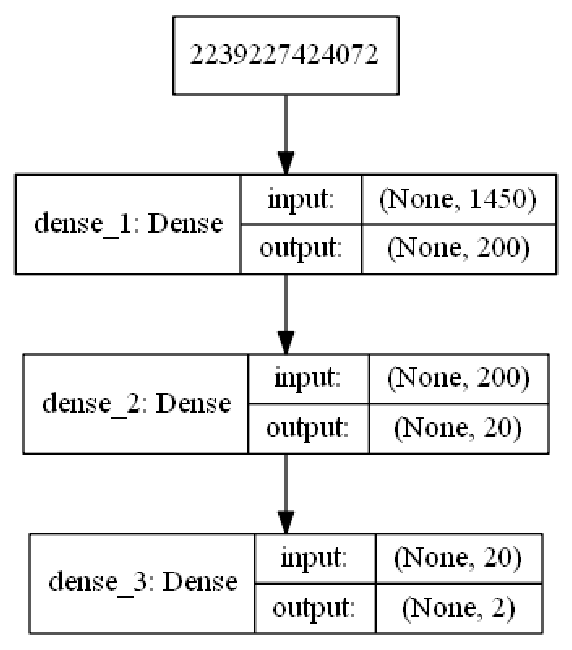

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
m = build_MLP(power_train_normal.shape[1], [200, 20], ['relu', 'relu'])
Init = m.get_weights()

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Training started:  2019-12-16 17:55:43.239807




100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [12:42<00:00,  2.98s/it]


Right candidate:  0x2b
Right key:  0x2b


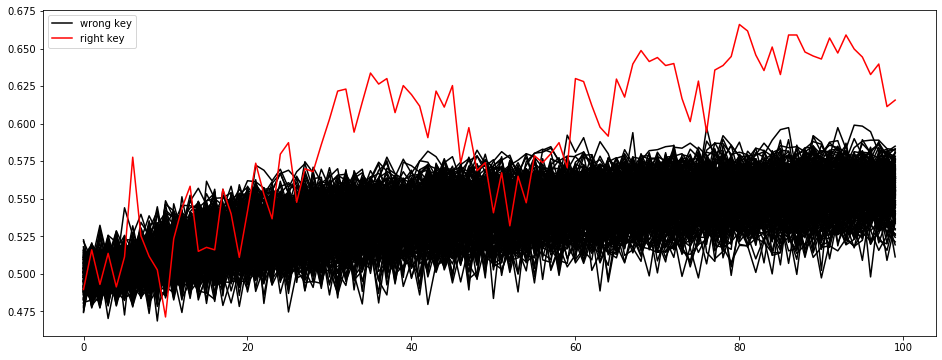

Training ended:  2019-12-16 18:08:26.719536
Elapsed 763.4797286987305


In [17]:
# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

right_key, accuracies = MLP_DDLA(m, Init, power_train_normal, pt_train, 0, 0x2b, 256, 100)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)

### 3.2. CNN-DDLA

In [18]:
def build_CNN(input_len, filters_num, kernels_size, activation_fuctions, poolings_size, batch_normalization):
    model = Sequential()
    
    model.add(Conv1D(filters_num[0], kernels_size[0], kernel_initializer = 'he_normal', activation = activation_fuctions[0], input_shape = (input_len, 1,), name = 'conv1d1'))
    model.add(AveragePooling1D(poolings_size[0], name = 'pooling1'))
    if batch_normalization[0] == 'T':
        model.add(BatchNormalization(name = 'batch_norm1'))
    
    for i, num_units in enumerate(filters_num[1:]):
        model.add(Conv1D(num_units, kernels_size[i + 1], kernel_initializer = 'he_normal', activation = activation_fuctions[i + 1], name = 'conv1d_{}'.format(i + 2)))
        model.add(AveragePooling1D(poolings_size[i + 1], name = 'pooling_{}'.format(i + 2)))
        if batch_normalization[i] == 'T':
            model.add(BatchNormalization(name = 'batch_norm_{}'.format(i + 2)))
    
    model.add(Flatten(name = 'flatten'))
    
    model.add(Dense(2, kernel_initializer = 'he_normal', activation = 'softmax', name = 'dense_{}'.format(len(filters_num) + 1)))
    
    model.summary(80)
    display_model_structure(model, saveTo = 'CNN for DDLA.png')
    
    z = Input(shape = (input_len, 1, ), name = 'input')
    sequence = model(z)
    
    c = Model(z, sequence, name = 'MLP')
    
    c.compile(optimizer = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08), loss = 'mean_squared_error', metrics = ['accuracy'])
    
    return c

In [19]:
def CNN_DDLA(c, Init, traces, pts, target_sbox, right_key, num_keycandi, num_epochs):
    accuracies = []
    best_acc = 0
    
    for k in tqdm(range(0, num_keycandi)):
        c.set_weights(Init)
    
        hypothesis = np.array(Sbox)[(pts[:, target_sbox] ^ k).astype(int)]
        lsb = hypothesis & 1
        lsb = to_categorical(lsb, 2)
        
        c.fit(x = traces, y = lsb, epochs = num_epochs, batch_size = 1024, verbose = 0)
        
        accuracies.append(c.history.history['acc'])
        if best_acc < c.history.history['acc'][num_epochs - 1]:
            best_acc = c.history.history['acc'][num_epochs - 1]
            c.save_weights('best model CNN.h5')
            right_candi = k
        
    print("Right candidate: ", hex(right_candi))
    print("Right key: ", hex(right_key))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, right_key - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    for k in range(right_key + 1, num_keycandi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    plt.plot(accuracies[~right_key], color = 'black', label = 'wrong key')
    plt.plot(accuracies[right_key], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    return right_key, accuracies

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv1d1 (Conv1D)                    (None, 1419, 4)                 132         
________________________________________________________________________________
pooling1 (AveragePooling1D)         (None, 709, 4)                  0           
________________________________________________________________________________
batch_norm1 (BatchNormalization)    (None, 709, 4)                  16          
________________________________________________________________________________
conv1d_2 (Conv1D)                   (None, 694, 4)                  260         
________________________________________________________________________________
pooling_2 (AveragePooling1D)        (None, 173, 4)                  0           
________________________________________________________________________________
batch_norm_2 (BatchNormaliza

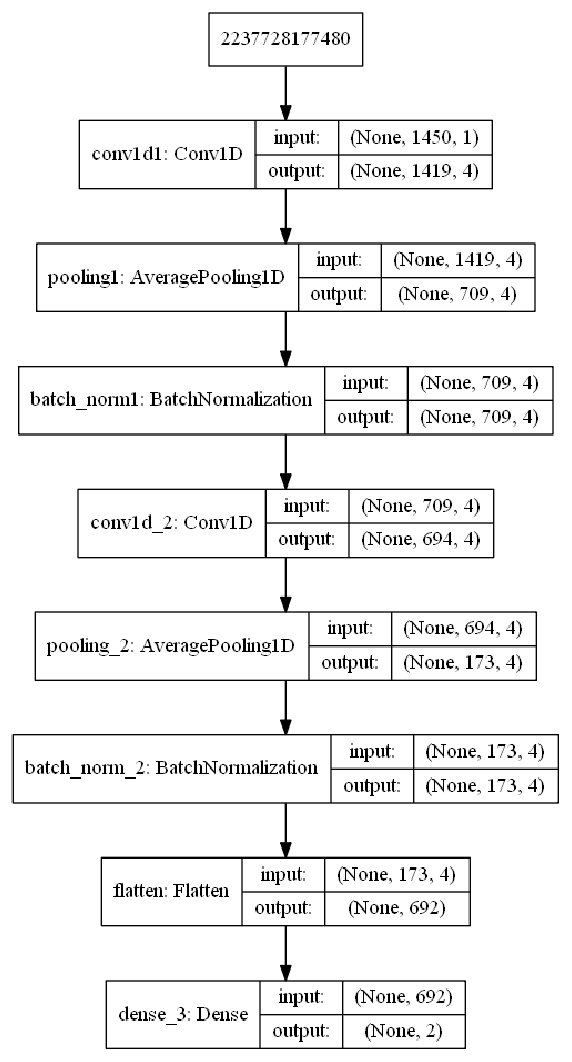

In [20]:
c = build_CNN(power_train_normal.shape[1], [4, 4], [32, 16], ['relu', 'relu'], [2, 4], ['T', 'T'])
Init = c.get_weights()

In [21]:
power_train_cnn = power_train_normal.reshape((power_train_normal.shape[0], power_train_normal.shape[1], 1))

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Training started:  2019-12-16 18:08:27.395589


100%|████████████████████████████████████████████████████████████████████████████████| 256/256 [19:54<00:00,  4.67s/it]


Right candidate:  0x2b
Right key:  0x2b


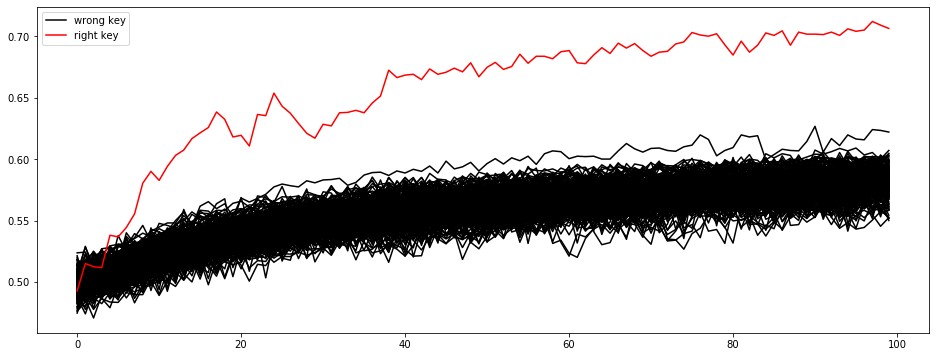

Training ended:  2019-12-16 18:28:22.474411
Elapsed 1195.0788218975067


In [22]:
# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

right_key, accuracies = CNN_DDLA(c, Init, power_train_cnn, pt_train, 0, 0x2b, 256, 100)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)

# 4. AES with Hiding Countermeasures
## 4.1. Collect Side-Channel Traces of AES with Hiding Countermeasures

In [23]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWLITEXMEGA'
CRYPTO_TARGET = 'NONE'

fw_path = '../chipwhisperer-develop/hardware/victims/firmware/simpleserial-aes_jh_hiding/simpleserial-aes-{}.hex'.format(PLATFORM)

In [24]:
%%bash -s "$PLATFORM" "$CRYPTO_TARGET"
cd ../chipwhisperer-develop/hardware/victims/firmware/simpleserial-aes_jh_hiding
make PLATFORM=$1 CRYPTO_TARGET=$2

rm -f -- simpleserial-aes-CWLITEXMEGA.hex
rm -f -- simpleserial-aes-CWLITEXMEGA.eep
rm -f -- simpleserial-aes-CWLITEXMEGA.cof
rm -f -- simpleserial-aes-CWLITEXMEGA.elf
rm -f -- simpleserial-aes-CWLITEXMEGA.map
rm -f -- simpleserial-aes-CWLITEXMEGA.sym
rm -f -- simpleserial-aes-CWLITEXMEGA.lss
rm -f -- objdir/*.o
rm -f -- objdir/*.lst
rm -f -- simpleserial-aes.s simpleserial.s XMEGA_AES_driver.s uart.s usart_driver.s xmega_hal.s
rm -f -- simpleserial-aes.d simpleserial.d XMEGA_AES_driver.d uart.d usart_driver.d xmega_hal.d
rm -f -- simpleserial-aes.i simpleserial.i XMEGA_AES_driver.i uart.i usart_driver.i xmega_hal.i
.
-------- begin --------
avr-gcc (GCC) 5.4.0
Copyright (C) 2015 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

.
Compiling C: simpleserial-aes.c
avr-gcc -c -mmcu=atxmega128d3 -I. -DNO_EXTRA_OPTS -fpack-struct -gdwarf-2 -DSS_VER=SS_VER_1_1 

In [25]:
scope = cw.scope()
target = cw.target(scope)
prog = cw.programmers.XMEGAProgrammer
scope.default_setup()
cw.program_target(scope, prog, fw_path)

Serial baud rate = 38400
XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 5163 bytes


In [26]:
ktp = cw.ktp.Basic() # object to generate fixed/random key and text (default fixed key, random text)
ktp.fixed_key = False
key, text = ktp.next()  # get our fixed key and random text

In [27]:
#scope.adc.offset = 200
scope.adc.samples = 6000

In [28]:
trace = cw.capture_trace(scope, target, text, key)
trace_len = len(trace.wave)

print("pt: ", hexlify(trace.textin))
print("random: ", hexlify(trace.key))
print("ct: ", hexlify(trace.textout))

output_notebook()
p = figure(sizing_mode='scale_width', plot_height=300)
p.line(range(0, trace_len), trace.wave, color='black')
show(p)

pt:  b'f121330a40496ce6eb266635c20990a0'
random:  b'2de111b2ae37638abc07cc7267327ba7'
ct:  b'1981430c9afd0e8980359aa3e46c6325'


Loading BokehJS ...

In [29]:
def collect_data(cw, ktp, scope, target, project, num_traces):
    traces = []
    pts = []
    
    # 파형 수집
    for i in tqdm(range(num_traces)):
        key, text = ktp.next()
        trace = cw.capture_trace(scope, target, text, key)
#        while trace is None:
#            trace = cw.capture_trace(scope, target, text, key)
        if trace is None:
            continue
        traces.append(trace.wave)
        pts.append(np.array(trace.textin, dtype=np.int))
        project.traces.append(trace)
    
    traces = np.array(traces)
    pts = np.array(pts)
    
    # 데이터(파형 및 평문) 셔플링
    rand_idx = np.arange(0, num_traces)
    np.random.shuffle(rand_idx)
    
    power_train = traces[rand_idx]
    pt_train = pts[rand_idx]
    
    return power_train, pt_train

In [30]:
num_train_traces = 25000
project = cw.create_project("projects/aes_hiding", overwrite = True)

power_train, pt_train = collect_data(cw, ktp, scope, target, project, num_train_traces)

project.save()

100%|████████████████████████████████████████████████████████████████████████████| 25000/25000 [15:17<00:00, 27.26it/s]


In [31]:
output_notebook()
p = figure(sizing_mode='scale_width', plot_height=300)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(project.waves[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, project.waves[i], color=color)
show(p)

Loading BokehJS ...

In [32]:
power_train_normal = power_train

for i in range(num_train_traces):
    power_train_normal[i] -= power_train_normal[i].mean()
    MIN = min(power_train_normal[i])
    MAX = max(power_train_normal[i])
    power_train_normal[i] = ((power_train_normal[i] - MIN)/(MAX - MIN) - 0.5) * 2

output_notebook()
p = figure(sizing_mode='scale_width', plot_height=300)

# create a color iterator
colors = itertools.cycle(palette)

x_range = range(0, len(power_train_normal[0]))
for i, color in zip(range(10), colors): #Adjust range(n) to plot certain traces
    p.line(x_range, power_train_normal[i], color=color)
show(p)

Loading BokehJS ...

## 4.2. Result of DDLA

In [33]:
def MLP_DDLA(m, Init, traces, pts, target_sbox, right_key, num_keycandi, num_epochs):
    accuracies = []
    best_acc = 0
    
    for k in tqdm(range(0, num_keycandi)):
        m.set_weights(Init)
        
        hypothesis = np.array(Sbox)[(pts[:, target_sbox] ^ k).astype(int)]
        lsb = hypothesis & 1
        lsb = to_categorical(lsb, 2)
        
        m.fit(x = traces, y = lsb, epochs = num_epochs, batch_size = 4096, verbose = 0)
        
        accuracies.append(m.history.history['acc'])
        if best_acc < m.history.history['acc'][num_epochs - 1]:
            best_acc = m.history.history['acc'][num_epochs - 1]
            m.save_weights('best model MLP.h5')
            right_candi = k
        
    print("Right candidate: ", hex(right_candi))
    print("Right key: ", hex(right_key))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, right_key - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    for k in range(right_key + 1, num_keycandi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    plt.plot(accuracies[~right_key], color = 'black', label = 'wrong key')
    plt.plot(accuracies[right_key], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    return right_key, accuracies

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_1 (Dense)                     (None, 450)                     2700450     
________________________________________________________________________________
dense_2 (Dense)                     (None, 30)                      13530       
________________________________________________________________________________
dense_3 (Dense)                     (None, 2)                       62          
Total params: 2,714,042
Trainable params: 2,714,042
Non-trainable params: 0
________________________________________________________________________________


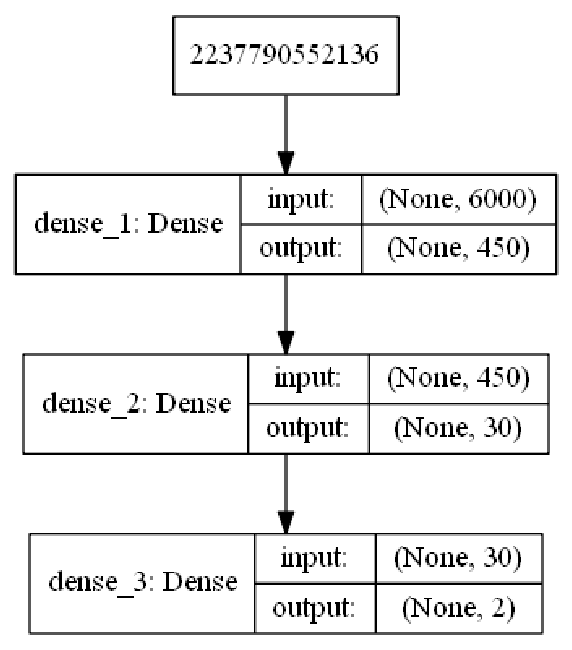

In [34]:
mh = build_MLP(power_train_normal.shape[1], [450, 30], ['relu', 'relu'])
Init = mh.get_weights()

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Training started:  2019-12-16 18:44:11.917629


100%|██████████████████████████████████████████████████████████████████████████████| 256/256 [5:40:52<00:00, 79.89s/it]


Right candidate:  0x98
Right key:  0x2b


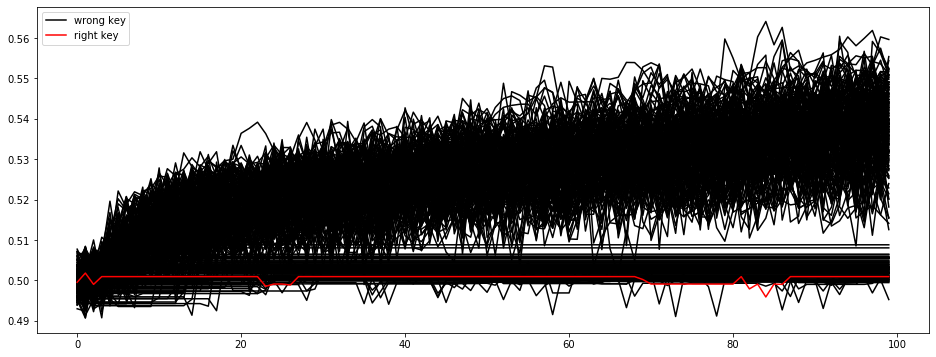

Training ended:  2019-12-17 00:25:05.081905
Elapsed 20453.164276361465


In [35]:
# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

right_key, accuracies = MLP_DDLA(mh, Init, power_train_normal, pt_train, 0, 0x2b, 256, 100)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)

## 4.3. Result of CNN-DDLA

In [36]:
def CNN_DDLA(c, Init, traces, pts, target_sbox, right_key, num_keycandi, num_epochs):
    accuracies = []
    best_acc = 0
    
    for k in tqdm(range(0, num_keycandi)):
        c.set_weights(Init)
    
        hypothesis = np.array(Sbox)[(pts[:, target_sbox] ^ k).astype(int)]
        lsb = hypothesis & 1
        lsb = to_categorical(lsb, 2)
        
        c.fit(x = traces, y = lsb, epochs = num_epochs, batch_size = 4096, verbose = 0)
        
        accuracies.append(c.history.history['acc'])
        if best_acc < c.history.history['acc'][num_epochs - 1]:
            best_acc = c.history.history['acc'][num_epochs - 1]
            c.save_weights('best model CNN.h5')
            right_candi = k
        
    print("Right candidate: ", hex(right_candi))
    print("Right key: ", hex(right_key))
    
    plt.figure(figsize = (16, 6))
    for k in range(0, right_key - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    for k in range(right_key + 1, num_keycandi - 1):
        plt.plot(accuracies[k], color = 'black', label = None)
    plt.plot(accuracies[~right_key], color = 'black', label = 'wrong key')
    plt.plot(accuracies[right_key], color = 'red', label = 'right key')
    plt.legend()
    plt.show()
    
    return right_key, accuracies

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
conv1d1 (Conv1D)                    (None, 5937, 4)                 260         
________________________________________________________________________________
pooling1 (AveragePooling1D)         (None, 2968, 4)                 0           
________________________________________________________________________________
batch_norm1 (BatchNormalization)    (None, 2968, 4)                 16          
________________________________________________________________________________
conv1d_2 (Conv1D)                   (None, 2937, 4)                 516         
________________________________________________________________________________
pooling_2 (AveragePooling1D)        (None, 734, 4)                  0           
________________________________________________________________________________
batch_norm_2 (BatchNormaliza

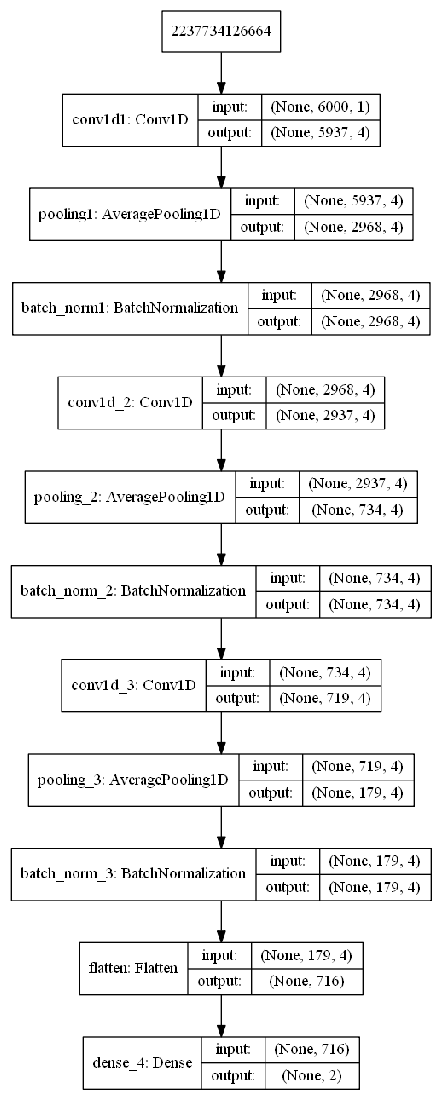

In [37]:
ch = build_CNN(power_train_normal.shape[1], [4, 4, 4], [64, 32, 16], ['relu', 'relu', 'relu'], [2, 4, 4], ['T', 'T', 'T'])
Init = ch.get_weights()

In [38]:
power_train_cnn = power_train_normal.reshape((power_train_normal.shape[0], power_train_normal.shape[1], 1))

  0%|                                                                                          | 0/256 [00:00<?, ?it/s]

Training started:  2019-12-17 00:25:06.039743


100%|█████████████████████████████████████████████████████████████████████████████| 256/256 [9:51:10<00:00, 138.56s/it]


Right candidate:  0x2b
Right key:  0x2b


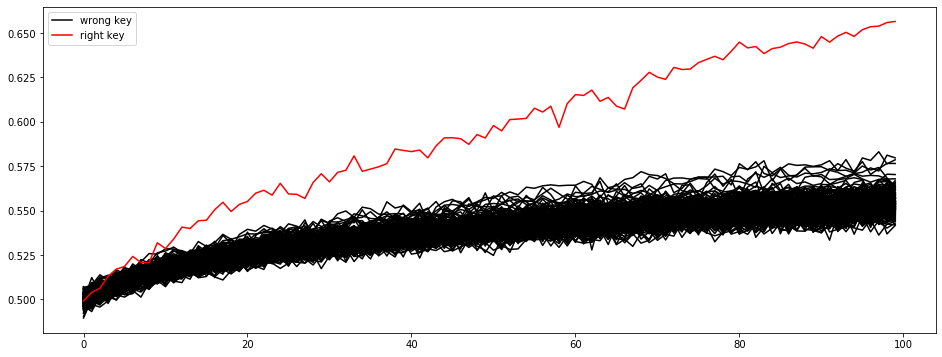

Training ended:  2019-12-17 10:16:16.649243
Elapsed 35470.60949969292


In [39]:
# 학습 시작 시간 측정
print("Training started: ", datetime.datetime.now())
start = time.time()

right_key, accuracies = CNN_DDLA(ch, Init, power_train_cnn, pt_train, 0, 0x2b, 256, 100)

# 학습 종료 시간 측정 및 소요 시간 계산
elapsed = time.time() - start
print("Training ended: ", datetime.datetime.now())
print("Elapsed", elapsed)